### Questions pairs.

In this notebook we are going to use this [dataset](https://www.kaggle.com/quora/question-pairs-dataset) from kaggle to perform question pair classification to detemine weather the questions are duplicates or not.


I've already downloaded the dataset and uploaded it on my google drive so that i can easly load it here in google colab.


### Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import csv, json, time
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

tf.__version__

'2.5.0'

### GPU

In [2]:
devices = tf.config.list_physical_devices("GPU")
try:
  tf.config.experimental.set_visible_devices(devices[0], "GPU")
  print("GPU set")
except RuntimeError as e:
  print(e)

GPU set


### SEED

In [3]:
SEED = 42
tf.random.set_seed(
    SEED
)
np.random.seed(SEED)

### Mounting the google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data

We will load the data from a single csv file. We are going to split that csv file into three file, the:
```
train.csv
test.csv
val.csv
```
And then save these files

In [5]:
base_path = '/content/drive/MyDrive/NLP Data/duplicates-questions'
os.listdir(base_path)

['questions.csv', 'val.csv', 'test.csv', 'train.csv']

In [6]:
file_path = os.path.join(base_path, "questions.csv")

### Read the data into a dataframe

In [7]:
dataframe = pd.read_csv(file_path)
dataframe.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Checking for null values

In [8]:
len(dataframe)

404351

In [9]:
dataframe.isnull().any()

id              False
qid1            False
qid2            False
question1        True
question2        True
is_duplicate    False
dtype: bool

Since we have null values we are going to drop all the rows that have null columns, meaning the rows that have columns with no data.

In [10]:
len(dataframe.dropna())

404348

### Splitting the sets

In [11]:
train, valid = train_test_split(dataframe, test_size=.005)
train, test = train_test_split(train, test_size=.005)

In [12]:
len(train), len(test), len(valid)

(400317, 2012, 2022)

Now we have `~40K` train data, `~2k` test data and `~2K` validation data, Let's save this in separate files.

In [13]:
val_path = "val.csv"
test_path = "test.csv"
train_path = "train.csv"

valid.to_csv(os.path.join(base_path, val_path), index=False)
test.to_csv(os.path.join(base_path, test_path), index=False)
train.to_csv(os.path.join(base_path, train_path), index=False)

print("files saved")

files saved


### Loading the files

In [14]:
train_dataframe = pd.read_csv(
    os.path.join(base_path, train_path)
)
val_dataframe = pd.read_csv(
    os.path.join(base_path, val_path)
)
test_dataframe = pd.read_csv(
    os.path.join(base_path, test_path)
)

In [15]:
train_dataframe.iloc[0]

id                                                199670
qid1                                              394042
qid2                                              394043
question1                     Do animals commit suicide?
question2       Can animals think of committing suicide?
is_duplicate                                           1
Name: 0, dtype: object

### Question Classes

We only have two classes, It's either the question are duplicates or not. So this is a binary classification.

```
0 -> not duplicates
1 -> duplicates
```

### Extracting the labels

In [16]:
train_labels = train_dataframe.is_duplicate.values.astype(np.float32)
val_labels = val_dataframe.is_duplicate.values.astype(np.float32)
test_labels = test_dataframe.is_duplicate.values.astype(np.float32)

train_labels[:7]

array([1., 0., 0., 1., 1., 0., 0.], dtype=float32)

For now we can say we are done with the labels.

### Features

Our model is going to accept two inputs, `question1` and `question2` and predict if the questions are duplicates or not. We are going to have two features in our for each set.

For the text we are only going to convert them to lower case using the `lambda` function `to_lower`.

In [17]:
to_lower = lambda sent: str(sent).lower()

In [18]:
train_questions1 = np.array(list(map(to_lower, train_dataframe.question1.values)))
train_questions2 = np.array(list(map(to_lower, train_dataframe.question2.values)))
assert all([(len(train_questions1) == len(train_labels)), (len(train_questions2) == len(train_labels))]), "train features and labels must have the same length"

val_questions1 = np.array(list(map(to_lower, val_dataframe.question1.values)))
val_questions2 = np.array(list(map(to_lower, val_dataframe.question2.values)))
assert all([(len(val_questions1) == len(val_labels)), (len(val_questions2) == len(val_labels))]), "val features and labels must have the same length"

test_questions1 = np.array(list(map(to_lower, test_dataframe.question1.values)))
test_questions2 = np.array(list(map(to_lower, test_dataframe.question2.values)))
assert all([(len(test_questions1) == len(test_labels)), (len(test_questions2) == len(test_labels))]), "test features and labels must have the same length"


In [19]:
test_questions1[:7]

array(['what would be the impact of quora getting hacked and all anonymous identities exposed?',
       'why is kneeling on rice used as a punishment?',
       'what are the most interesting products and innovations that federated investors is coming out with in 2016?',
       'what does it feel like to study psychology?',
       'how can you determine the valence electrons in calcium?',
       "where is jk rowling's house?",
       'who was the first human to go the moon?'], dtype='<U273')

### Preprocessing Features(Questions)

Each feature will be processed as follows:

1. Create a vocabulary
2. Create a `stoi` from each sentencs
3. pad the sentences to have the same size

**Note** - During creation of the vocabulary we are going to use the `train` set. The model should not have an idea about the validation set, because we want the validation set to represent the test set as mush as possible.

### Vocab size, (aka) the number of unique words.

In [20]:
from collections import Counter
from nltk.tokenize import word_tokenize

In [21]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
train_questions1[1], train_questions2[1], train_labels[1]

('what does abc mean?', 'what is abc?', 0.0)

In [23]:
question_1_counter = Counter()
question_2_counter = Counter()
for sent in train_questions1:
  question_1_counter.update(word_tokenize(sent))

for sent in train_questions2:
  question_2_counter.update(word_tokenize(sent))

In [24]:
print(question_1_counter.most_common(3))
print(question_2_counter.most_common(3))

[('?', 420704), ('the', 186932), ('what', 161680)]
[('?', 423357), ('the', 186596), ('what', 159317)]


In [25]:
question_1_vocab = len(question_1_counter)
question_2_vocab = len(question_2_counter)
question_1_vocab, question_2_vocab

(83402, 78695)

We have `~83K` unique words in the first questions set and `~80K` unique words in the second questions.

### Word vectors

We are going to have 1 tokenizer for all these two sets of questions and we are going to call `fit_on_texts()` on th `first questions` since it is the one that has more unique words. 

We could also use the `second questions` as well. For the vocabulary size ofcause we should use the `first questions` vocab_size if we choose to go with `first questions`.

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
tokenizer = Tokenizer(num_words=question_1_vocab)
tokenizer.fit_on_texts(train_questions1)

In [28]:
word_indices = tokenizer.word_index
word_indices_reversed = dict([
    (v, k) for (k, v) in word_indices.items()
])

### Helper functions

We will create some helper function that converts sequences to text and text to sequences. These function will be used for inference later on.

In [29]:
def seq_to_text(sequences):
  return " ".join(word_indices_reversed[i] for i in sequences )

def text_to_seq(sent):
  words = word_tokenize(sent.lower())
  sequences = []
  for word in words:
    try:
      sequences.append(word_indices[word])
    except:
      sequences.append(0)
  return sequences

### Pretrained embeding weights

Since this model is using RNN's we are going to use the `pretrained glove.6B` word embeddings. I've already uploaded these word embedding on my google colab so that we can load them as follows:

In [30]:
embedding_path = "/content/drive/MyDrive/NLP Data/glove.6B/glove.6B.100d.txt"


In [31]:
embedding_dict = dict()
with open(embedding_path, encoding="utf8") as glove:
  for line in glove:
    records = line.split();
    word = records[0]
    vectors = np.asarray(records[1: ], dtype=np.float32)
    embedding_dict[word] = vectors

In [32]:
print(len(embedding_dict))
embedding_dict["what"].shape

400000


(100,)

### Embedding matrix
We will then create an embedding matrix that will suit our data.

In [33]:
embedding_matrix = np.zeros((question_1_vocab, 100))

for word, index in word_indices.items():
  vector = embedding_dict.get(word)
  if vector is not None:
    try:
      embedding_matrix[index] = vector
    except IndexError or Exception:
      pass

In [34]:
len(embedding_matrix)

83402

### Creating Sequences

In [35]:
train_sequences_1 = tokenizer.texts_to_sequences(train_questions1)
train_sequences_2 = tokenizer.texts_to_sequences(train_questions2)

val_sequences_1 = tokenizer.texts_to_sequences(val_questions1)
val_sequences_2 = tokenizer.texts_to_sequences(val_questions2)

In [36]:
val_sequences_1[0], val_questions1[0]

([4, 21, 1, 68036, 84], 'how does the boggart work?')

### Testing our helper functions

In [37]:
seq_to_text(val_sequences_1[0])

'how does the boggart work'

In [38]:
text_to_seq("this is why the unknownnnn word ?")

[68, 3, 16, 1, 0, 243, 0]

### Pad sequences

Our final step is to pad our suquences to have the same length. We are going to do this on the train and validation sets only.

In [39]:
max_words = 100

train_tokens_padded_1 = pad_sequences(
    train_sequences_1, 
    maxlen=max_words, 
    padding="post", 
    truncating="post"
)

train_tokens_padded_2 = pad_sequences(
    train_sequences_2, 
    maxlen=max_words, 
    padding="post", 
    truncating="post"
)

val_tokens_padded_1 = pad_sequences(
    val_sequences_1, 
    maxlen=max_words, 
    padding="post", 
    truncating="post"
)
val_tokens_padded_2 = pad_sequences(
    val_sequences_2, 
    maxlen=max_words, 
    padding="post", 
    truncating="post"
)

In [40]:
assert len(val_tokens_padded_1[0]) == len(val_tokens_padded_1[1]), "The tokens are not padded"

### Building the model.

Our model will be using the `Functional` API instead of the `Subclassing` or the `Sequential` API. This is a toy model that will have the following inputs and output structures.

```
  question1 ------->
                    | Concatenate layer |-------> output [0, 1]
  question2 ------->
```


In [41]:
forward_layer = keras.layers.GRU(
   128, return_sequences=True, dropout=.5,
   name="gru_forward_layer"
)
backward_layer = keras.layers.LSTM(
   128, return_sequences=True, dropout=.5,
   go_backwards=True, name="lstm_backward_layer"
)


question_1_input = keras.layers.Input(shape=(100, ), name="question_1_input")
question_2_input = keras.layers.Input(shape=(100, ), name="question_2_input")

question_1_embedding =  keras.layers.Embedding(
          question_1_vocab, 100, 
          input_length=max_words,
          weights=[embedding_matrix], 
          trainable=True,
          name = "embedding_layer_1"
      )(question_1_input)

question_2_embedding =  keras.layers.Embedding(
          question_1_vocab, 100, 
          input_length=max_words,
          weights=[embedding_matrix], 
          trainable=True,
          name = "embedding_layer_2"
      )(question_2_input)

question_1_bidirectional =  keras.layers.Bidirectional(
        forward_layer,
        backward_layer = backward_layer,
        name= "bidirectional_layer_1"
        )(question_1_embedding)

question_2_bidirectional =  keras.layers.Bidirectional(
        forward_layer,
        backward_layer = backward_layer,
        name= "bidirectional_layer_2"
        )(question_2_embedding)

concatenate_layer = keras.layers.Concatenate(name="concatenate_layer_layer")([question_1_bidirectional, question_2_bidirectional])

gru_layer = keras.layers.GRU(
          512, return_sequences=True,
          dropout=.5,
          name= "gru_layer"
  )(concatenate_layer)
lstm_layer = keras.layers.LSTM(
          512, return_sequences=True,
          dropout=.5,
          name="lstm_layer"
  )(gru_layer)

pooling_layer = keras.layers.GlobalAveragePooling1D(
          name="average_pooling_layer"
      )(lstm_layer)

dense_1 = keras.layers.Dense(64, activation='relu', name="dense_1")(pooling_layer)
dropout_1 = keras.layers.Dropout(rate= .5, name="dropout_layer_0")(dense_1)
dense_2 = keras.layers.Dense(512, activation='relu', name="dense_2")(dropout_1)
dropout_2 =  keras.layers.Dropout(rate= .5, name="dropout_layer_1")(dense_2)
dense_3 = keras.layers.Dense(128, activation='relu', name="dense_3")(dropout_2)
dropout_3 = keras.layers.Dropout(rate= .5, name="dropout_layer_2")(dense_3)
output_layer = keras.layers.Dense(1, activation='sigmoid', name="output_layer")(dropout_3)


model = keras.Model(inputs=[question_1_input, question_2_input], outputs=[output_layer])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
question_1_input (InputLayer)   [(None, 100)]        0                                            
__________________________________________________________________________________________________
question_2_input (InputLayer)   [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_layer_1 (Embedding)   (None, 100, 100)     8340200     question_1_input[0][0]           
__________________________________________________________________________________________________
embedding_layer_2 (Embedding)   (None, 100, 100)     8340200     question_2_input[0][0]           
______________________________________________________________________________________________

Our model has `~20M` trainable parameters, Let's visualize how the model looks.

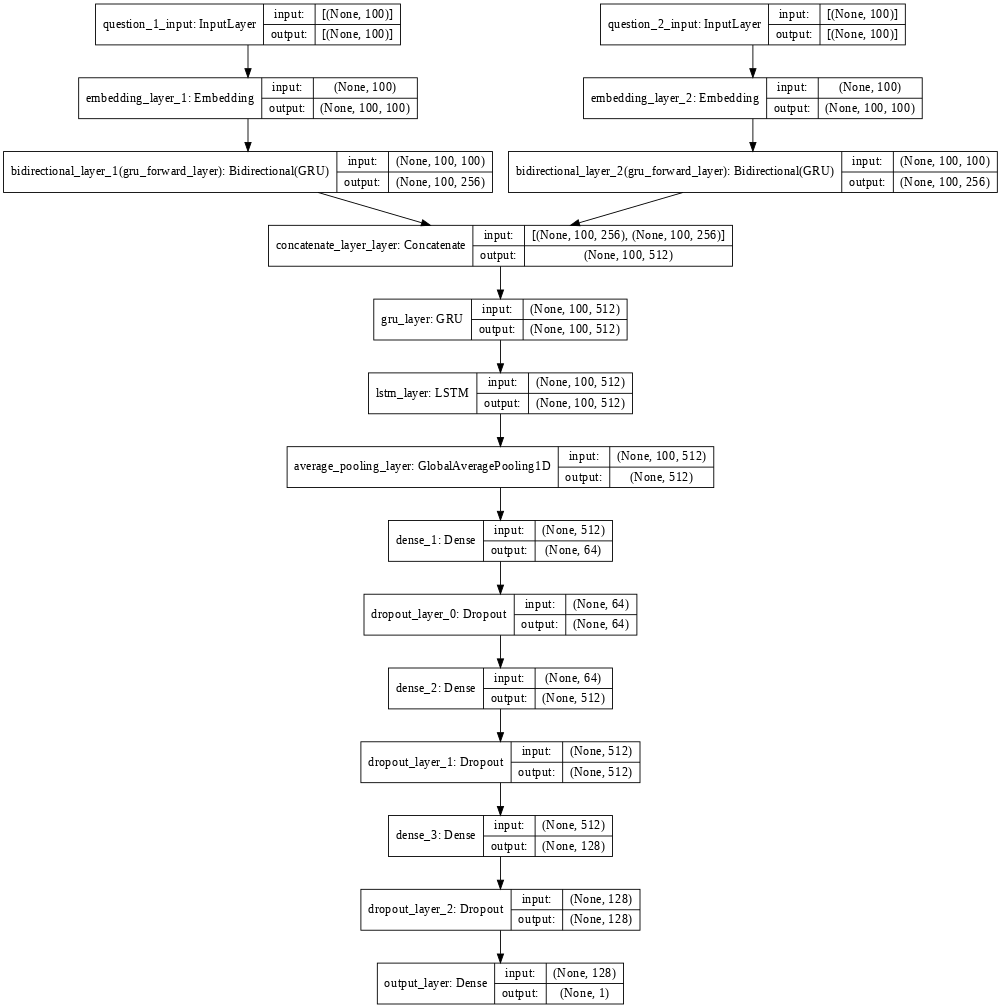

In [42]:
keras.utils.plot_model(model, dpi=64, show_shapes=True)

### Compiling the model

Again we are going to compile our model and we will use the `EalyStopping` call back.

In [43]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)

model.compile(
    loss = keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer = keras.optimizers.Adam(1e-3, 0.5),
    metrics = ["accuracy"]
)

### How long should we train the model?
We are going to train the model for more epochs, as soon as the model loss stop decreasing we will stop.

In [44]:
EPOCHS = 20

history = model.fit(
    x =[
      train_tokens_padded_1, train_tokens_padded_2              
    ], y=train_labels,
    validation_data = (
        [val_tokens_padded_1, val_tokens_padded_2  ], val_labels
    ),
    verbose = 1,
    epochs = EPOCHS,
    batch_size = 128,
    shuffle = True,
    validation_batch_size = 16,
    callbacks = [early_stopping]
)


Epoch 1/20
3128/3128 [==============================] - 873s 276ms/step - loss: 0.5256 - accuracy: 0.7348 - val_loss: 0.4908 - val_accuracy: 0.7789
Epoch 2/20
3128/3128 [==============================] - 857s 274ms/step - loss: 0.4500 - accuracy: 0.7824 - val_loss: 0.4554 - val_accuracy: 0.7913
Epoch 3/20
3128/3128 [==============================] - 854s 273ms/step - loss: 0.4112 - accuracy: 0.8046 - val_loss: 0.4399 - val_accuracy: 0.8046
Epoch 4/20
3128/3128 [==============================] - 854s 273ms/step - loss: 0.3839 - accuracy: 0.8193 - val_loss: 0.4178 - val_accuracy: 0.8150
Epoch 5/20
3128/3128 [==============================] - 854s 273ms/step - loss: 0.3621 - accuracy: 0.8315 - val_loss: 0.4122 - val_accuracy: 0.8136
Epoch 6/20
3128/3128 [==============================] - 853s 273ms/step - loss: 0.3433 - accuracy: 0.8411 - val_loss: 0.4256 - val_accuracy: 0.8042
Epoch 7/20
3128/3128 [==============================] - 852s 272ms/step - loss: 0.3288 - accuracy: 0.8488 - val_

### Evaluating the model.

We are going to evaluate the model on the test data. Remeber in the evaluate method we need to pass the data in the same shape we trained on so the test features and labels need to be processed.

### Converting test data to numeric and then pad it.

In [45]:
def text_to_padded_sequences(sent):
  tokens = text_to_seq(sent)
  padded_tokens = pad_sequences([tokens], maxlen=max_words, padding="post", truncating="post")
  return tf.squeeze(padded_tokens)

test_question1_padded =  np.array(list(map(text_to_padded_sequences, test_questions1)))
test_question2_padded =  np.array(list(map(text_to_padded_sequences, test_questions2)))

model.evaluate(
    [
     test_question1_padded, test_question2_padded
    ],
    test_labels,
    verbose = 1,
    batch_size = 32
)

63/63 [==============================] - 2s 24ms/step - loss: 0.4300 - accuracy: 0.7932


[0.4299863278865814, 0.7932405471801758]

As we can seee we are able to get an accuracy of `~80%` on the test data. Which can be improved 

### Model inference (making predictions)

In [46]:
from prettytable import PrettyTable

In [63]:
def tabulate(column_names, data, max_characters:int, title:str):
  table = PrettyTable(column_names)
  table.align[column_names[0]] = "l"
  table.align[column_names[1]] = "l"
  table.title = title
  table._max_width = {column_names[0] :max_characters, column_names[1] :max_characters}
  for row in data:
    table.add_row(row)
  print(table)

In [67]:
def predict(model, qn1, qn2, real_label=None):
  classes = ["not duplicate", "duplicate"]
  qn1_tokens = text_to_seq(qn1)
  qn2_tokens = text_to_seq(qn2)

  qn1_padded_tokens = pad_sequences([qn1_tokens], maxlen=max_words, 
                                padding="post", truncating="post")
  qn2_padded_tokens = pad_sequences([qn2_tokens], maxlen=max_words, 
                                padding="post", truncating="post")
  probability = tf.squeeze(model.predict([qn1_padded_tokens, qn2_padded_tokens]), 0)[0]
  classLabel = np.round(probability).astype('int32')

  probability = probability if probability >= .5  else 1- probability
  table_headers =["KEY", "VALUE"]
  table_data = [
        ["Question 1", qn1],
        ["Question2", qn2],
        ["PREDICTED CLASS",  classLabel],
        ["PREDICTED CLASS NAME",  classes[classLabel]],
        ["REAL CLASS",  real_label],
        ["REAL CLASS NAME",  classes[real_label]],
        ["CONFIDENCE OVER OTHER CLASSES", f'{ probability * 100:.2f}%'],
             
    ]
  title = "Duplicate Questions"
  tabulate(table_headers, table_data, 50, title=title)
predict(model, test_questions1[0], test_questions2[2], int(test_labels[0]))

+------------------------------------------------------------------------------------+
|                                Duplicate Questions                                 |
+-------------------------------+----------------------------------------------------+
| KEY                           | VALUE                                              |
+-------------------------------+----------------------------------------------------+
| Question 1                    | what would be the impact of quora getting hacked   |
|                               | and all anonymous identities exposed?              |
| Question2                     | what are the most interesting products and         |
|                               | innovations that federal signal is coming out with |
|                               | in 2016?                                           |
| PREDICTED CLASS               | 0                                                  |
| PREDICTED CLASS NAME          | not dupli

### Making predictions on the test data.

In [68]:
for label, qn1, qn2 in zip(test_labels[:10], test_questions1, test_questions2):
  predict(model, qn1, qn2, int(label))

+------------------------------------------------------------------------------------+
|                                Duplicate Questions                                 |
+-------------------------------+----------------------------------------------------+
| KEY                           | VALUE                                              |
+-------------------------------+----------------------------------------------------+
| Question 1                    | what would be the impact of quora getting hacked   |
|                               | and all anonymous identities exposed?              |
| Question2                     | what would the consequences be if someone hacked   |
|                               | the anonymity feature on quora and everyone who    |
|                               | thought they were anonymous would be exposed?      |
| PREDICTED CLASS               | 0                                                  |
| PREDICTED CLASS NAME          | not dupli

### Saving the model.

In [73]:
model.save("questions_model.h5")
print("saved!!")

saved!!


In [74]:
loaded = keras.models.load_model("questions_model.h5")

In [75]:
loaded.evaluate(
        [
     test_question1_padded, test_question2_padded
    ],
    test_labels,
    verbose = 1,
    batch_size = 32
)

63/63 [==============================] - 3s 28ms/step - loss: 0.4300 - accuracy: 0.7932


[0.4299863278865814, 0.7932405471801758]